📂 구조 데이터 로드: D:/dataset/binary_dataset_128_1.npy
✅ 기존 결과 memmap 사용: D:/dataset/spectra_result/spectra_latest_1.npy shape=(100000, 3, 301) dtype=float32
✅ valid memmap 사용: D:/dataset/spectra_result/spectra_latest_valid_1.npy shape=(100000,)
📌 dataset length(N_STRUCT) = 100000
🚀 실행 범위: 0 ~ 99999 (총 100000)
🧠 세션 리셋 주기: 100
📝 로그: D:/dataset/spectra_result/run_failures.log
🔁 재개 인덱스(체크포인트/커밋 기준): 42200 (progress last_committed=42199)

🚀 FDTD 실행 시작 (struct_idx=42200부터)



Total:  42%|███████████▊                | 42200/100000 [00:00<?, ?it/s, chunk=42200~42299 idx=42200 ok=0 fail=0 skip=0]

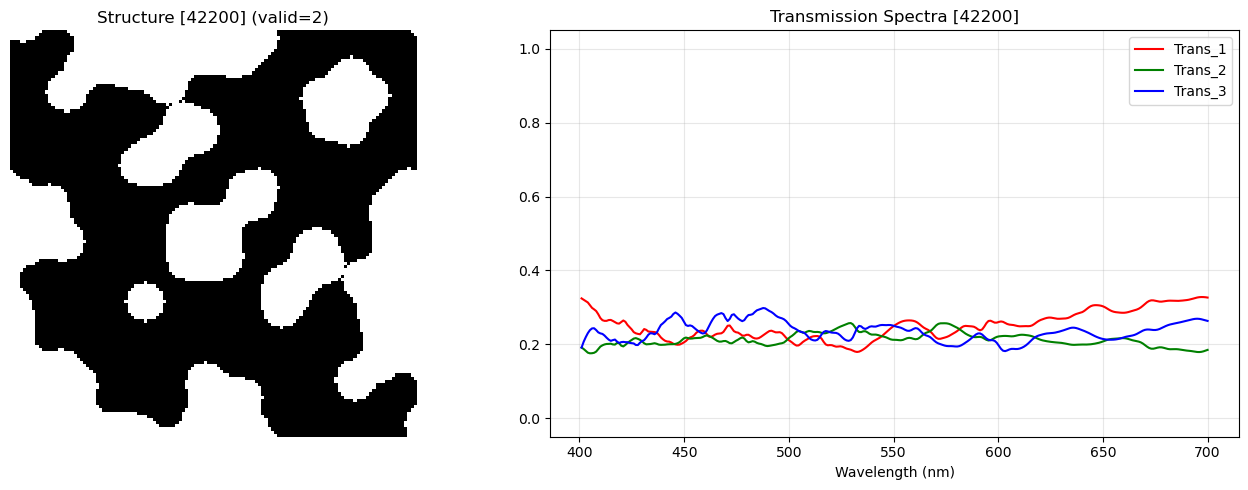

Total:  42%|██████▊         | 42203/100000 [01:32<480:59:39, 29.96s/it, chunk=42200~42299 idx=42202 ok=3 fail=0 skip=0]

In [ ]:
import sys
import os
import time
import traceback
import gc
import subprocess
import csv
from io import StringIO
import threading

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm  # 텍스트 tqdm 강제(위젯 로딩/중복 출력 이슈 회피)
from IPython.display import display
%matplotlib inline

# ==========================================
# Warning 무시 (lumapi import 전에)
# ==========================================
import warnings
warnings.filterwarnings("ignore", category=SyntaxWarning)

# ==========================================
# [중요] Jupyter Notebook 환경 변수 설정
# ==========================================
LUMERICAL_BASE = r"C:\Program Files\Lumerical\v241"
API_PATH = os.path.join(LUMERICAL_BASE, "api", "python")
BIN_PATH = os.path.join(LUMERICAL_BASE, "bin")

if API_PATH not in sys.path:
    sys.path.append(API_PATH)
if BIN_PATH not in os.environ.get("PATH", ""):
    os.environ["PATH"] = os.environ.get("PATH", "") + ";" + BIN_PATH

import lumapi

# ==========================
# 1. 설정 및 경로
# ==========================
GDS_DIR          = r"D:\dataset\gds"
FDTD_FILE        = r"D:\dataset\air_SiN_2um_NA.fsp"
RESULT_FILE      = r"D:\dataset\spectra_result\spectra_latest_1.npy"
VALID_FILE       = r"D:\dataset\spectra_result\spectra_latest_valid_1.npy"
STRUCT_DATA_PATH = r"D:\dataset\binary_dataset_128_1.npy"
LOG_FILE         = r"D:\dataset\spectra_result\run_failures.log"
PROGRESS_FILE    = r"D:\dataset\spectra_result\progress_checkpoint_1.txt"

def norm_path(p: str) -> str:
    return os.path.abspath(p).replace("\\", "/")

GDS_DIR          = norm_path(GDS_DIR)
FDTD_FILE        = norm_path(FDTD_FILE)
RESULT_FILE      = norm_path(RESULT_FILE)
VALID_FILE       = norm_path(VALID_FILE)
STRUCT_DATA_PATH = norm_path(STRUCT_DATA_PATH)
LOG_FILE         = norm_path(LOG_FILE)
PROGRESS_FILE    = norm_path(PROGRESS_FILE)

# ==========================
# 2. 파라미터
# ==========================
LAYER_MAP       = "1:0"
TARGET_MATERIAL = "Si3N4 (Silicon Nitride) - Phillip"
Z_min, Z_max    = 0e-9, 600e-9

START_IDX       = 0
NUM_RUNS        = 100000          # 최대 실행 개수(데이터셋 길이보다 크면 자동으로 잘림)
SPECTRAL_POINTS = 301

RESUME_IDX      = 0               # 시작 인덱스(체크포인트/커밋 기준이 우선)
CHUNK_SIZE      = 100             # (선택) 100~200 권장 (이미 반영한 값 유지)

OUT_DTYPE       = np.float32

# 디버깅/확인용 시각화
LIVE_PLOT       = True            # 저장/결과 확인하려면 True
PLOT_EVERY      = 50              # 1이면 tqdm/출력 충돌 + 매우 느림 (20~100 권장)

# tqdm postfix 갱신 주기(초)
POSTFIX_EVERY_SEC = 2.0

# ✅ 세션 로드 재시도 파라미터 (FDTD load 단계 불안정 대응)
MAX_LOAD_RETRY = 5
LOAD_RETRY_SLEEP_SEC = 5.0

# ✅ 좀비 프로세스 정리 파라미터
KILL_ON_LOAD_FAIL = True
KILL_COOLDOWN_SEC = 2.0

# ==========================
# ✅ (추가) 단계별 타임아웃 (중지되기 쉬운 지점에 적용)
# ==========================
TIMEOUT_SESSION_CREATE_SEC  = 60       # lumapi.FDTD(hide=True)
TIMEOUT_READY_PING_SEC      = 60       # wait_fdtd_ready()
TIMEOUT_LOAD_FSP_SEC        = 60      # fdtd.load()
TIMEOUT_SWITCH_LAYOUT_SEC   = 60       # fdtd.switchtolayout()
TIMEOUT_GDSIMPORT_EVAL_SEC  = 60      # fdtd.eval(gdsimport script)
TIMEOUT_RUN_SEC             = 60 * 3  # fdtd.run() (예: 30분)
TIMEOUT_EXTRACT_SEC         = 60      # fdtd.eval(EXTRACT_SCRIPT) + getv
TIMEOUT_CLOSE_SEC           = 60       # fdtd.close()

# ==========================
# 3. 로깅 / 체크포인트
# ==========================
def log_failure(struct_idx: int, stage: str, msg: str, exc: Exception = None, extra: dict = None):
    ts = time.strftime("%Y-%m-%d %H:%M:%S")
    line = f"[{ts}] struct_idx={struct_idx} stage={stage} msg={msg}\n"
    if extra:
        line += f"  extra={extra}\n"
    if exc is not None:
        line += "  " + "".join(traceback.format_exception(type(exc), exc, exc.__traceback__)) + "\n"
    with open(LOG_FILE, "a", encoding="utf-8") as f:
        f.write(line)

def save_progress(last_committed_idx: int):
    with open(PROGRESS_FILE, "w", encoding="utf-8") as f:
        f.write(str(int(last_committed_idx)))

def load_progress(default: int) -> int:
    if not os.path.exists(PROGRESS_FILE):
        return int(default)
    try:
        with open(PROGRESS_FILE, "r", encoding="utf-8") as f:
            s = f.read().strip()
        if s == "":
            return int(default)
        return int(s)
    except Exception as e:
        log_failure(-1, "load_progress", "failed to read progress file", e, extra={"path": PROGRESS_FILE})
        return int(default)

# ==========================
# 3.5 좀비 프로세스 정리 유틸 (PID 기반)
# ==========================
def kill_fdtd_processes(reason: str, struct_idx: int = -1, extra: dict = None):
    """
    Windows에서 'fdtd'가 포함된 프로세스를 tasklist로 찾아 PID 기준으로 강제 종료.
    - /F: 강제 종료
    - /T: 자식 프로세스까지 종료
    + tasklist 스냅샷/매칭 결과 로그에 남김
    """
    extra = dict(extra or {})
    extra.update({"reason": reason})

    # 1) tasklist 스냅샷 확보 (로그용)
    tasklist_stdout = ""
    try:
        cp_list = subprocess.run(
            ["tasklist", "/FO", "CSV", "/NH"],
            capture_output=True,
            text=True
        )
        tasklist_stdout = cp_list.stdout or ""
        tasklist_stderr = cp_list.stderr or ""
        log_failure(
            struct_idx, "tasklist",
            f"tasklist executed (rc={cp_list.returncode})",
            extra={
                **extra,
                "stdout_tail": tasklist_stdout[-2000:],
                "stderr_tail": tasklist_stderr[-2000:]
            }
        )
    except Exception as e:
        log_failure(struct_idx, "tasklist_error", "tasklist failed", e, extra=extra)

    # 2) CSV 파싱하여 'fdtd' 포함 프로세스 PID 수집
    matched = []
    pids = []
    try:
        rows = list(csv.reader(StringIO(tasklist_stdout)))
        for r in rows:
            if not r or len(r) < 2:
                continue
            imagename = (r[0] or "").strip().strip('"')
            pid = (r[1] or "").strip().strip('"')
            if "fdtd" in imagename.lower():
                info = {
                    "image": imagename,
                    "pid": pid,
                    "session": r[2].strip().strip('"') if len(r) > 2 else "",
                    "mem": r[4].strip().strip('"') if len(r) > 4 else ""
                }
                matched.append(info)
                if pid.isdigit():
                    pids.append(pid)

        log_failure(
            struct_idx, "tasklist_match",
            f"matched fdtd processes: {len(pids)}",
            extra={**extra, "matched": matched}
        )
    except Exception as e:
        log_failure(struct_idx, "tasklist_parse_error", "failed to parse tasklist output", e, extra=extra)

    # 3) PID 기준 강제 종료
    for pid in pids:
        try:
            cpk = subprocess.run(
                ["taskkill", "/F", "/T", "/PID", pid],
                capture_output=True,
                text=True
            )
            log_failure(
                struct_idx, "taskkill_pid",
                f"taskkill executed for pid={pid} (rc={cpk.returncode})",
                extra={**extra, "stdout": (cpk.stdout or "")[-500:], "stderr": (cpk.stderr or "")[-500:]}
            )
        except Exception as e:
            log_failure(struct_idx, "taskkill_pid_error", f"taskkill failed for pid={pid}", e, extra=extra)

    time.sleep(KILL_COOLDOWN_SEC)
    try:
        gc.collect()
    except Exception:
        pass

# ==========================
# 3.6 FDTD 준비(Ready) 핸드셰이크
# ==========================
def wait_fdtd_ready(fdtd, timeout_sec: float = 30.0, poll_sec: float = 0.5):
    """
    FDTD 프로세스가 초기화되어 lumapi 호출을 받을 준비가 될 때까지 가벼운 eval로 핑(ping).
    """
    t0 = time.time()
    last_exc = None
    while (time.time() - t0) < timeout_sec:
        try:
            fdtd.eval("1+1;")  # 최소 핑
            return
        except Exception as e:
            last_exc = e
            time.sleep(poll_sec)
    raise RuntimeError("FDTD not ready (ping timeout)") from last_exc

# ==========================
# ✅ (추가) 단계별 타임아웃 + 강제종료 + 재시도용 래퍼
# ==========================
def _stage_timeout_guard(stage: str, timeout_sec: float, struct_idx: int, chunk: tuple, extra: dict = None):
    """
    - 별도 타이머 스레드가 timeout이 지나면 fdtd 프로세스 강제 종료
    - 호출이 반환된 후에도 timeout이 발동했던 경우엔 RuntimeError로 재시도 유도
    """
    done = threading.Event()
    fired = {"v": False}
    extra = dict(extra or {})
    extra.update({"stage": stage, "timeout_sec": float(timeout_sec), "chunk": tuple(chunk)})

    def _timer():
        if not done.wait(timeout_sec):
            fired["v"] = True
            log_failure(struct_idx, "timeout", f"stage timed out: {stage}", extra=extra)
            kill_fdtd_processes(reason=f"timeout_{stage}", struct_idx=struct_idx, extra=extra)

    th = threading.Thread(target=_timer, daemon=True)
    th.start()
    return done, fired

def run_stage_with_timeout(stage: str, timeout_sec: float, struct_idx: int, chunk: tuple, fn, extra: dict = None):
    """
    fn() 실행을 감싸서, 타임아웃 발생 시 fdtd 프로세스 강제 종료 후 RuntimeError를 던져
    바깥 retry 로직으로 '재실행(새 세션)' 되게 만든다.
    """
    done, fired = _stage_timeout_guard(stage, timeout_sec, struct_idx, chunk, extra=extra)
    try:
        return fn()
    finally:
        done.set()
        if fired["v"]:
            # timeout이 한 번이라도 발동했으면, 결과를 신뢰하지 않고 상위에서 재시도
            raise RuntimeError(f"Stage timeout fired: {stage}")

def safe_close_fdtd(fdtd, struct_idx: int, chunk: tuple):
    if fdtd is None:
        return
    try:
        def _close():
            try:
                fdtd.close()
            except Exception:
                pass
        run_stage_with_timeout("close", TIMEOUT_CLOSE_SEC, struct_idx, chunk, _close)
    except Exception as e:
        # close 중 타임아웃/오류는 로그만 남기고 진행 (어차피 프로세스는 kill 시도됨)
        log_failure(struct_idx, "close_error", "fdtd close failed or timed out", e, extra={"chunk": tuple(chunk)})

# ==========================
# 4. memmap 유틸 (결과 + valid 2-phase)
# ==========================
def open_or_create_result_memmap(path: str, shape: tuple, dtype=np.float32):
    if os.path.exists(path):
        try:
            arr = np.load(path, mmap_mode="r+")
            if arr.shape == shape and arr.dtype == dtype:
                print(f"✅ 기존 결과 memmap 사용: {path} shape={arr.shape} dtype={arr.dtype}")
                return arr

            print(f"⚠️ 기존 결과 파일 shape/dtype 불일치: {arr.shape}/{arr.dtype} -> 새로 생성 후 일부 복사")
            tmp_path = path.replace(".npy", f".tmp_{int(time.time())}.npy")
            new_arr = np.lib.format.open_memmap(tmp_path, mode="w+", dtype=dtype, shape=shape)

            o0 = min(arr.shape[0], shape[0])
            o1 = min(arr.shape[1], shape[1])
            o2 = min(arr.shape[2], shape[2])
            new_arr[:o0, :o1, :o2] = arr[:o0, :o1, :o2].astype(dtype, copy=False)
            new_arr.flush()
            del new_arr, arr

            os.replace(tmp_path, path)
            arr2 = np.load(path, mmap_mode="r+")
            print(f"✅ 결과 파일 재생성 완료(memmap): {path} shape={arr2.shape} dtype={arr2.dtype}")
            return arr2
        except Exception as e:
            log_failure(-1, "open_memmap", "failed to open existing result file", e, extra={"path": path})

    arr = np.lib.format.open_memmap(path, mode="w+", dtype=dtype, shape=shape)
    arr[:] = 0
    arr.flush()
    print(f"✨ 새 결과 memmap 생성: {path} shape={shape} dtype={dtype}")
    return arr

def open_or_create_valid_memmap(path: str, length: int):
    if os.path.exists(path):
        try:
            v = np.load(path, mmap_mode="r+")
            if v.shape == (length,) and v.dtype == np.uint8:
                print(f"✅ valid memmap 사용: {path} shape={v.shape}")
                return v

            print(f"⚠️ valid 파일 길이/형식 불일치: {v.shape}/{v.dtype} -> 새로 생성 후 일부 복사")
            tmp_path = path.replace(".npy", f".tmp_{int(time.time())}.npy")
            new_v = np.lib.format.open_memmap(tmp_path, mode="w+", dtype=np.uint8, shape=(length,))
            new_v[:] = 0
            n = min(v.shape[0], length)
            new_v[:n] = np.array(v[:n], dtype=np.uint8, copy=False)
            new_v.flush()
            del new_v, v
            os.replace(tmp_path, path)
            v2 = np.load(path, mmap_mode="r+")
            return v2
        except Exception as e:
            log_failure(-1, "open_valid", "failed to open existing valid file", e, extra={"path": path})

    v = np.lib.format.open_memmap(path, mode="w+", dtype=np.uint8, shape=(length,))
    v[:] = 0
    v.flush()
    print(f"✨ valid memmap 생성: {path} shape={v.shape}")
    return v

# ==========================
# 5. 데이터 로드 (인덱스 정합성 기준)
# ==========================
if os.path.exists(STRUCT_DATA_PATH):
    print(f"📂 구조 데이터 로드: {STRUCT_DATA_PATH}")
    struct_data = np.load(STRUCT_DATA_PATH, mmap_mode="r")
else:
    raise FileNotFoundError(f"❌ 구조 파일 없음: {STRUCT_DATA_PATH}")

N_STRUCT = int(struct_data.shape[0])

all_spectra = open_or_create_result_memmap(
    RESULT_FILE, (N_STRUCT, 3, SPECTRAL_POINTS), dtype=OUT_DTYPE
)
valid_mask = open_or_create_valid_memmap(VALID_FILE, N_STRUCT)

# 실행 범위 클램프
START_IDX = max(0, int(START_IDX))
END_IDX_EXCL = min(N_STRUCT, START_IDX + int(NUM_RUNS))

# 미커밋(2) 흔적은 0으로 되돌림 (실행 범위만 스캔)
_vm_sub = np.asarray(valid_mask[START_IDX:END_IDX_EXCL])
_stale_rel = np.where(_vm_sub == 2)[0]
if _stale_rel.size > 0:
    _stale_abs = _stale_rel + START_IDX
    valid_mask[_stale_abs] = 0
    valid_mask.flush()

# ✅ 재개 인덱스: "마지막 커밋 기준"
last_committed_from_file = load_progress(default=START_IDX - 1)
resume_from_checkpoint = last_committed_from_file + 1

user_resume = max(START_IDX, int(RESUME_IDX))
RESUME_IDX = max(user_resume, resume_from_checkpoint)
RESUME_IDX = min(RESUME_IDX, END_IDX_EXCL)

# 안전장치: 이미 커밋된(valid==1) 구간은 앞으로 스킵
while RESUME_IDX < END_IDX_EXCL and int(valid_mask[RESUME_IDX]) == 1:
    RESUME_IDX += 1

print(f"📌 dataset length(N_STRUCT) = {N_STRUCT}")
print(f"🚀 실행 범위: {START_IDX} ~ {END_IDX_EXCL-1} (총 {END_IDX_EXCL-START_IDX})")
print(f"🧠 세션 리셋 주기: {CHUNK_SIZE}")
print(f"📝 로그: {LOG_FILE}")
print(f"🔁 재개 인덱스(체크포인트/커밋 기준): {RESUME_IDX} (progress last_committed={last_committed_from_file})")

# ==========================
# 6. 시각화 함수
# ==========================
PLOT_HANDLE = None  # 노트북에서 같은 출력 영역 업데이트용

def plot_live_status(struct_idx, image_data, spectra, wavelength=None, valid_state=None):
    global PLOT_HANDLE

    try:
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))

        ax_img = axes[0]
        ax_img.imshow(image_data.squeeze(), cmap="gray", origin="lower")
        ax_img.set_title(f"Structure [{struct_idx}] (valid={valid_state})")
        ax_img.axis("off")

        ax_plot = axes[1]
        x_axis = wavelength if wavelength is not None else np.arange(len(spectra[0]))
        x_label = "Wavelength (nm)" if wavelength is not None else "Index"

        ax_plot.plot(x_axis, -spectra[0], "r-", label="Trans_1")
        ax_plot.plot(x_axis, -spectra[1], "g-", label="Trans_2")
        ax_plot.plot(x_axis, -spectra[2], "b-", label="Trans_3")

        ax_plot.set_title(f"Transmission Spectra [{struct_idx}]")
        ax_plot.set_xlabel(x_label)
        ax_plot.set_ylim(-0.05, 1.05)
        ax_plot.legend()
        ax_plot.grid(True, alpha=0.3)

        plt.tight_layout()

        # ✅ clear_output 없이 같은 출력 영역만 업데이트
        if PLOT_HANDLE is None:
            PLOT_HANDLE = display(fig, display_id=True)
        else:
            PLOT_HANDLE.update(fig)

        plt.close(fig)

    except Exception as e:
        print(f"❌ Plot Error 발생: {e}")

# ==========================
# 7. GDS import 스크립트
# ==========================
def script_import_like_original(gds_path: str, struct_idx: int) -> str:
    cellA = f"structure_{struct_idx:05d}"
    cellB = f"structure_{struct_idx}"
    return f'''
try{{ select("IMPORTED_GDS"); delete; }} catch(errMsg);

import_ok = 0;
used_cell = "";
import_err = "";

try{{
    gdsimport("{gds_path}", "{cellA}", "{LAYER_MAP}", "{TARGET_MATERIAL}", {Z_min}, {Z_max});
    set("name", "IMPORTED_GDS");
    import_ok = 1;
    used_cell = "{cellA}";
}} catch(import_err);

if (import_ok == 0) {{
    import_err = "";
    try{{
        gdsimport("{gds_path}", "{cellB}", "{LAYER_MAP}", "{TARGET_MATERIAL}", {Z_min}, {Z_max});
        set("name", "IMPORTED_GDS");
        import_ok = 1;
        used_cell = "{cellB}";
    }} catch(import_err);
}}
'''

# ==========================
# 8. 결과 추출 스크립트 (원본 방식)
# ==========================
EXTRACT_SCRIPT = '''
if (haveresult("Trans_1")) { T1=transmission("Trans_1"); f_vec=getdata("Trans_1","f"); } else { T1=0; f_vec=0; }
if (haveresult("Trans_2")) { T2=transmission("Trans_2"); } else { T2=0; }
if (haveresult("Trans_3")) { T3=transmission("Trans_3"); } else { T3=0; }
'''

# ==========================
# 9. 메인 루프
# ==========================
print(f"\n🚀 FDTD 실행 시작 (struct_idx={RESUME_IDX}부터)\n")

wavelength_data = None
last_committed = RESUME_IDX - 1

total_total = END_IDX_EXCL - START_IDX
total_initial = RESUME_IDX - START_IDX

ok_cnt = 0
fail_cnt = 0
skip_cnt = 0

last_postfix_t = time.time()

# ✅ tqdm 한 줄 유지 + 청크 이동 메시지는 postfix로만 표시
with tqdm(
    total=total_total,
    initial=total_initial,
    desc="Total",
    dynamic_ncols=True,
    leave=True,
    mininterval=0.2,
    ascii=False
) as pbar:

    # 초기 postfix
    pbar.set_postfix_str(f"chunk={RESUME_IDX}~{min(RESUME_IDX+CHUNK_SIZE-1, END_IDX_EXCL-1)}")

    for chunk_start in range(RESUME_IDX, END_IDX_EXCL, CHUNK_SIZE):
        chunk_end = min(chunk_start + CHUNK_SIZE, END_IDX_EXCL)

        pbar.set_postfix_str(
            f"chunk={chunk_start}~{chunk_end-1} idx={chunk_start} ok={ok_cnt} fail={fail_cnt} skip={skip_cnt}"
        )

        chunk_success = []
        current_idx_for_postfix = chunk_start

        loaded = False
        last_load_exc = None

        for attempt in range(1, MAX_LOAD_RETRY + 1):
            fdtd = None
            try:
                # ✅ (추가) 세션 생성에도 타임아웃
                def _create_session():
                    return lumapi.FDTD(hide=True)

                fdtd = run_stage_with_timeout(
                    "session_create",
                    TIMEOUT_SESSION_CREATE_SEC,
                    struct_idx=chunk_start,
                    chunk=(chunk_start, chunk_end-1),
                    fn=_create_session
                )

                # ✅ (추가) ready ping 타임아웃
                run_stage_with_timeout(
                    "ready_ping",
                    TIMEOUT_READY_PING_SEC,
                    struct_idx=chunk_start,
                    chunk=(chunk_start, chunk_end-1),
                    fn=lambda: wait_fdtd_ready(fdtd, timeout_sec=TIMEOUT_READY_PING_SEC, poll_sec=0.5)
                )

                # ✅ (추가) load 타임아웃
                run_stage_with_timeout(
                    "load_fsp",
                    TIMEOUT_LOAD_FSP_SEC,
                    struct_idx=chunk_start,
                    chunk=(chunk_start, chunk_end-1),
                    fn=lambda: fdtd.load(FDTD_FILE)
                )

                loaded = True

                for struct_idx in range(chunk_start, chunk_end):
                    current_idx_for_postfix = struct_idx
                    try:
                        if int(valid_mask[struct_idx]) == 1:
                            skip_cnt += 1
                            continue

                        # ✅ (추가) switchtolayout 타임아웃
                        run_stage_with_timeout(
                            "switchtolayout",
                            TIMEOUT_SWITCH_LAYOUT_SEC,
                            struct_idx=struct_idx,
                            chunk=(chunk_start, chunk_end-1),
                            fn=lambda: fdtd.switchtolayout()
                        )

                        gdsA = os.path.join(GDS_DIR, f"structure_{struct_idx:05d}.gds")
                        gdsB = os.path.join(GDS_DIR, f"structure_{struct_idx}.gds")

                        if os.path.exists(gdsA):
                            gds_path = norm_path(gdsA)
                        elif os.path.exists(gdsB):
                            gds_path = norm_path(gdsB)
                        else:
                            fail_cnt += 1
                            log_failure(struct_idx, "gds_missing", "GDS file not found", extra={"A": gdsA, "B": gdsB})
                            continue

                        # ✅ (추가) gdsimport eval 타임아웃
                        try:
                            run_stage_with_timeout(
                                "gdsimport_eval",
                                TIMEOUT_GDSIMPORT_EVAL_SEC,
                                struct_idx=struct_idx,
                                chunk=(chunk_start, chunk_end-1),
                                fn=lambda: fdtd.eval(script_import_like_original(gds_path, struct_idx)),
                                extra={"gds_path": gds_path}
                            )
                            import_ok = int(np.array(fdtd.getv("import_ok")).ravel()[0])
                        except Exception as e:
                            # timeout도 여기로 들어온다(raise RuntimeError). -> fail 처리
                            fail_cnt += 1
                            log_failure(struct_idx, "gdsimport_eval", "eval failed during gdsimport (or timeout)", e, extra={"gds_path": gds_path})
                            continue

                        if import_ok != 1:
                            fail_cnt += 1
                            try:
                                import_err = fdtd.getv("import_err")
                                used_cell = fdtd.getv("used_cell")
                            except Exception:
                                import_err, used_cell = "<unreadable>", "<unreadable>"
                            log_failure(
                                struct_idx, "gdsimport", "gdsimport failed",
                                extra={"gds_path": gds_path, "used_cell": str(used_cell), "import_err": str(import_err)}
                            )
                            continue

                        # ✅ (추가) run 타임아웃
                        try:
                            run_stage_with_timeout(
                                "run",
                                TIMEOUT_RUN_SEC,
                                struct_idx=struct_idx,
                                chunk=(chunk_start, chunk_end-1),
                                fn=lambda: fdtd.run(),
                                extra={"gds_path": gds_path}
                            )
                        except Exception as e:
                            fail_cnt += 1
                            log_failure(struct_idx, "run", "fdtd.run() failed (or timeout)", e, extra={"gds_path": gds_path})
                            # 레이아웃으로 돌아가기(이것도 타임아웃 보호)
                            try:
                                run_stage_with_timeout(
                                    "switchtolayout_after_run_fail",
                                    TIMEOUT_SWITCH_LAYOUT_SEC,
                                    struct_idx=struct_idx,
                                    chunk=(chunk_start, chunk_end-1),
                                    fn=lambda: fdtd.switchtolayout()
                                )
                            except Exception:
                                pass
                            continue

                        # ✅ (추가) extract 타임아웃 (eval + getv 전체를 하나로)
                        try:
                            def _extract_all():
                                fdtd.eval(EXTRACT_SCRIPT)
                                r1 = np.array(fdtd.getv("T1")).ravel()
                                r2 = np.array(fdtd.getv("T2")).ravel()
                                r3 = np.array(fdtd.getv("T3")).ravel()

                                nonlocal_wavelength = None
                                if nonlocal_wavelength is None:
                                    f_data = np.array(fdtd.getv("f_vec")).ravel()
                                    return r1, r2, r3, f_data
                                return r1, r2, r3, None

                            r1, r2, r3, f_data = run_stage_with_timeout(
                                "extract",
                                TIMEOUT_EXTRACT_SEC,
                                struct_idx=struct_idx,
                                chunk=(chunk_start, chunk_end-1),
                                fn=_extract_all,
                                extra={"gds_path": gds_path}
                            )

                            if wavelength_data is None and f_data is not None:
                                if f_data.size > 1:
                                    wavelength_data = (299792458.0 / f_data) * 1e9

                        except Exception as e:
                            fail_cnt += 1
                            log_failure(struct_idx, "extract", "failed to extract results (or timeout)", e, extra={"gds_path": gds_path})
                            continue

                        if r1.size != SPECTRAL_POINTS or r2.size != SPECTRAL_POINTS or r3.size != SPECTRAL_POINTS:
                            fail_cnt += 1
                            log_failure(
                                struct_idx, "shape_mismatch", "spectra length mismatch",
                                extra={"sizes": (int(r1.size), int(r2.size), int(r3.size)), "gds_path": gds_path}
                            )
                            continue

                        current_spectra = np.stack([r1, r2, r3], axis=0).astype(OUT_DTYPE, copy=False)

                        valid_mask[struct_idx] = 2
                        all_spectra[struct_idx, :, :] = current_spectra
                        chunk_success.append(struct_idx)
                        ok_cnt += 1

                        if LIVE_PLOT and (struct_idx % PLOT_EVERY == 0):
                            plot_live_status(
                                struct_idx,
                                struct_data[struct_idx],
                                current_spectra,
                                wavelength_data,
                                valid_state=int(valid_mask[struct_idx])
                            )

                    finally:
                        pbar.update(1)

                        now = time.time()
                        if now - last_postfix_t >= POSTFIX_EVERY_SEC:
                            pbar.set_postfix_str(
                                f"chunk={chunk_start}~{chunk_end-1} "
                                f"idx={current_idx_for_postfix} ok={ok_cnt} fail={fail_cnt} skip={skip_cnt}"
                            )
                            last_postfix_t = now

                all_spectra.flush()
                if chunk_success:
                    valid_mask[np.array(chunk_success, dtype=np.int64)] = 1
                valid_mask.flush()

                if chunk_success:
                    last_committed = max(last_committed, max(chunk_success))
                    save_progress(last_committed)

                break  # 성공적으로 청크 완료

            except Exception as e:
                last_load_exc = e
                log_failure(
                    chunk_start, "session_load_retry",
                    f"FDTD session/load failed (attempt {attempt}/{MAX_LOAD_RETRY})",
                    e, extra={"chunk": (chunk_start, chunk_end-1)}
                )

                # ✅ (추가) 실패/타임아웃이면 항상 fdtd 프로세스 정리 (PID 기반)
                if KILL_ON_LOAD_FAIL:
                    kill_fdtd_processes(
                        reason="retry_after_exception_or_timeout",
                        struct_idx=chunk_start,
                        extra={"attempt": attempt, "chunk": (chunk_start, chunk_end-1)}
                    )

                try:
                    gc.collect()
                except Exception:
                    pass
                time.sleep(LOAD_RETRY_SLEEP_SEC)

            finally:
                # ✅ (추가) close도 타임아웃 보호 + 실패 시 kill
                try:
                    safe_close_fdtd(fdtd, struct_idx=chunk_start, chunk=(chunk_start, chunk_end-1))
                except Exception:
                    pass
                fdtd = None

        if not loaded:
            log_failure(
                chunk_start, "session",
                "FDTD session crashed (load unrecoverable)",
                last_load_exc, extra={"chunk": (chunk_start, chunk_end-1)}
            )

            if KILL_ON_LOAD_FAIL:
                kill_fdtd_processes(
                    reason="load_unrecoverable",
                    struct_idx=chunk_start,
                    extra={"chunk": (chunk_start, chunk_end-1)}
                )
            continue

print("\n🎉 완료")
print(f"✅ 마지막 커밋 struct_idx: {last_committed}")
print(f"📝 실패 로그: {LOG_FILE}")
print(f"🧾 체크포인트: {PROGRESS_FILE}")
